# Convolutional Neural Network

In this notebook, we train a CNN to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://github.com/iqDF/100-days-DeepLearning/blob/master/assets/cifar-10.png?raw=1' width=50% height=50%/>

## Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)
Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [12]:
import numpy as np
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# Device configuration
device = torch.device('cuda:0' if train_on_gpu else 'cpu')

if train_on_gpu:
    print("Training on GPU device mode on.")
else:
    print("Training on CPU device.")

Training on GPU device mode on.


## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [4]:
from torchvision import datasets # sample available torchvision datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# define dataloader args
num_workers = 2
batch_size = 40
val_set_ratio = 0.2

# define afine image transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# choose the training and test dataset from Pytorch CIFAR
train_set = datasets.CIFAR10('data/', train=True, 
                           transform=transform, download=True)
test_set = datasets.CIFAR10('data/', train=False,
                         transform=transform, download=True)

# split train - validation set 80/20
n_train = len(train_set)
split_idx = int(np.floor(n_train * val_set_ratio))
indices = list(range(n_train))
np.random.shuffle(indices)
train_idx, val_idx = indices[split_idx:], indices[:split_idx]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# define data loader for train - val - test
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
val_loader = DataLoader(train_set, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

# specify image classes
num_classes = 10
classes = ["airplane", "automobile", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck"]

0it [00:00, ?it/s]

100%|█████████▉| 170369024/170498071 [00:41<00:00, 1618255.77it/s]

Files already downloaded and verified


## Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

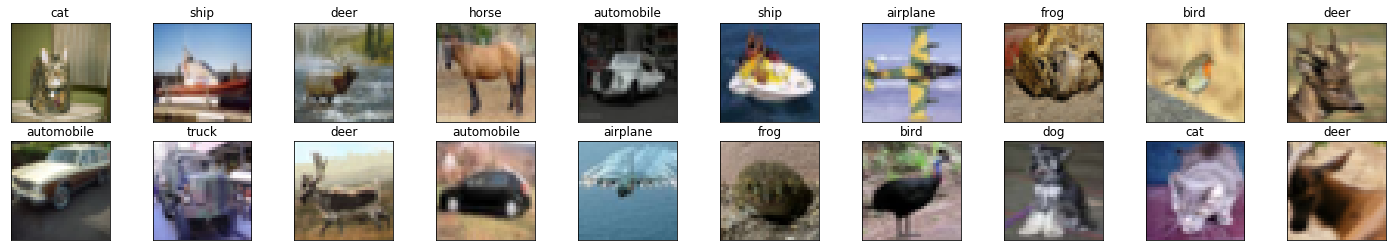

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# get image size
rgb_img = np.squeeze(images[0])
n_channel = rgb_img.shape[0]
rimg = rgb_img[0]
cifar_size = rimg.shape[0] # shape: size x size

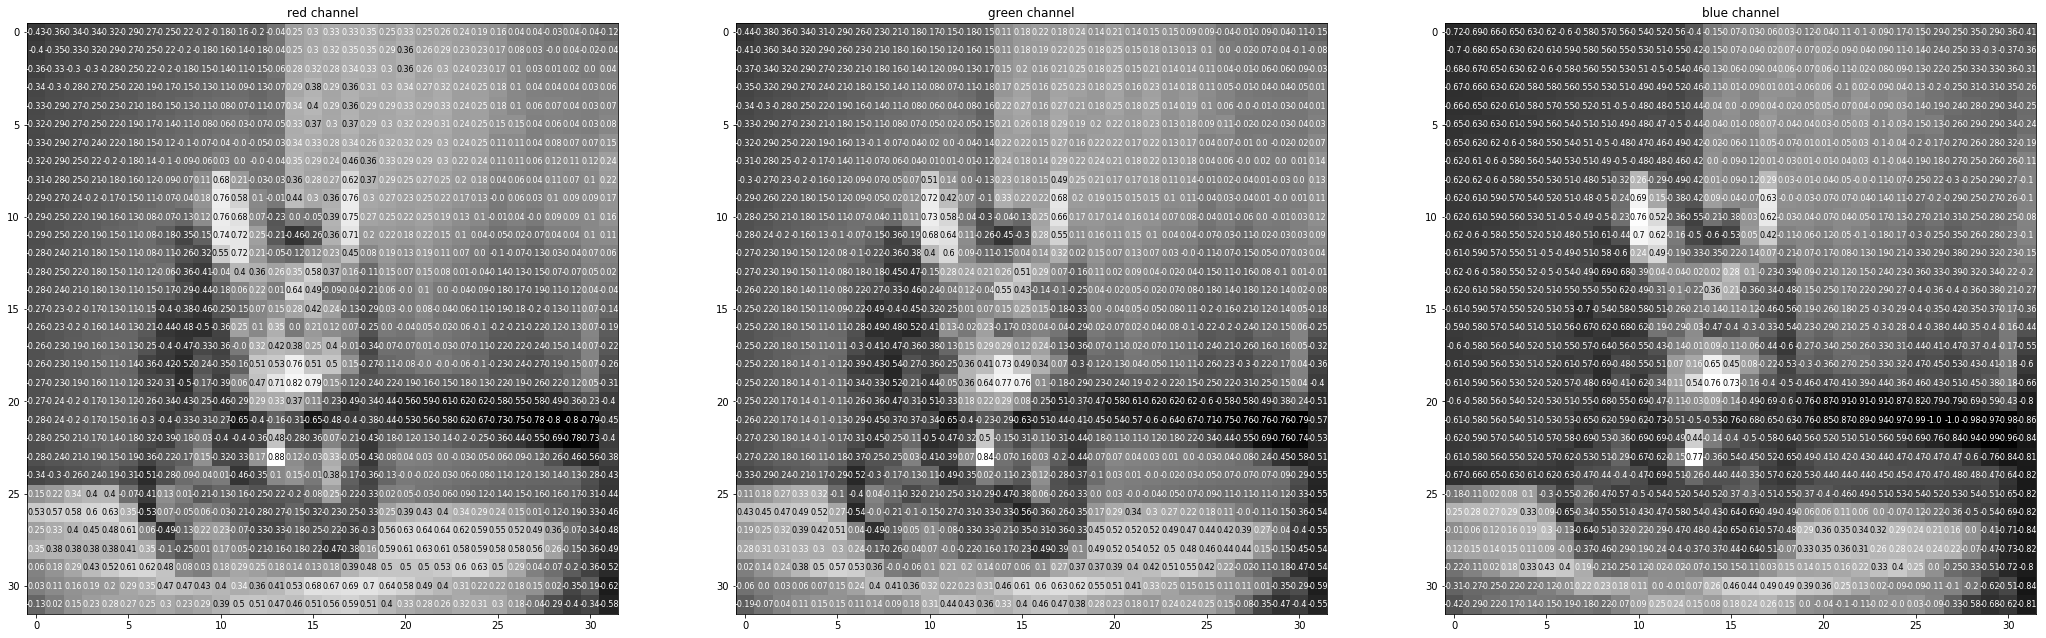

In [8]:
rgb_img = np.squeeze(images[0])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]): #rgb
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Defining the Network Architecture
This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:

Convolutional layers, which can be thought of as stack of filtered images.
Maxpooling layers, which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.
A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='https://github.com/iqDF/100-days-DeepLearning/blob/master/assets/3-layer-conv.png?raw=1' height=50% width=50% />

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at this PyTorch classification example or this, more complex Keras example to help decide on a final structure.

### Output volume for a convolutional layer


We can compute the spatial size of the output volume as a function of the input volume size ($W$), the kernel/filter size ($F$), the stride with which they are applied ($S$), and the amount of zero padding used ($P$) on the border. The correct formula for calculating how many neurons define the output $W$ is given by $$W = {(W-F+2P)\over S}+1 $$
For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, input_size, out_class=10):

        # if input_size is given in (s,s) format
        if isinstance(input_size, (list,tuple)):
            input_size = input_size[0]

        super(SimpleCNN, self).__init__()

        # 1st convolutional layer -> output size: (16 x in_size x in_size) 
        self.conv2d_1 = nn.Conv2d(3, 16, kernel_size=(3,3), padding=1)

        # 2nd convolutional layer -> output size: (32 x in_size/2 x in_size/2)
        self.conv2d_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        
        # 3rd convolutional layer -> output size: (64 x in_size/4 x in_size/4)
        self.conv2d_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        
        # flatten size for fc layer
        flatten_size = 64*int(input_size/4)*int(input_size/4)
        
        # fully-connected layer, remember to flatten input
        drop_p = 0.5
        self.fc = nn.Sequential(
            nn.Linear(flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(p=drop_p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=drop_p),
            nn.Linear(128, out_class)
        )
        
    def forward(self, X):
        # forward flow to convolutional layers
        X = self.conv2d_1(X)
        X = self.conv2d_2(X)
        X = self.conv2d_3(X)
        
        # flatten size
        X = X.reshape(X.size(0), -1)
        X = self.fc(X)
        
        return F.log_softmax(X, dim=1)


In [0]:
model = SimpleCNN(input_size=cifar_size, out_class=num_classes).to(device)


## Specify Loss Function and Optimizer
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; this PyTorch classification example or this, more complex Keras example. Pay close attention to the value for learning rate as this value determines how your model converges to a small error.


In [0]:
# Hyper parameters
num_epochs = 15
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train the Network
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [69]:
# track change in validation loss
val_loss_min = np.Inf 

# Training the model
for e in range(num_epochs):
    print("\n Epoch: {} \t------------------------------------------------------------------------------------".format(e))

    # initialise training and val loss
    train_loss = 0.0
    val_loss = 0.0
    
    # initialise training and val acc
    train_acc = 0.0
    val_acc = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # clear optimizer grad
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        
        # update and keep track training loss
        train_loss += loss.item() * images.size(0)
        
        # update accuracy
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(torch.eq(preds, labels)).item() # n_correct
    
    # decay learning rate every 10 epochs
    if (e+1)%5 == 0:
        learning_rate = learning_rate * 0.1
        
    ######################
    # validate the model #
    ######################
    model.eval()
    
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # update and keep track val loss
        val_loss += loss.item() * images.size(0)
        
        # update number of correct answers
        _, preds = torch.max(outputs, 1)
        val_acc += torch.sum(torch.eq(preds, labels)).item() # n_correct
   
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    val_loss = val_loss/len(val_loader.sampler)
    
    # calculate average accuracy
    train_acc = train_acc/len(train_loader.sampler)
    val_acc = val_acc/len(val_loader.sampler)

    # print training/validation loss
    print("\tTraining Loss {:.4f} \tValidation Loss {:.4f} "
          "\tTraining Acc {:.4f} \tValidation Acc {:.4f}".format(train_loss,
                                                                val_loss,
                                                                train_acc,
                                                                val_acc))

    # save model if validation loss decreased
    if val_loss < (val_loss_min*0.97):
        print("\tSaving models from epoch {}".format(e))
        torch.save(model.state_dict(), 'model_cifar10.pt')
        val_loss_min = val_loss



 Epoch: 0 	------------------------------------------------------------------------------------
	Training Loss 0.7443 	Validation Loss 0.7891 	Training Acc 0.7409 	Validation Acc 0.7289
	Saving models from epoch 0

 Epoch: 1 	------------------------------------------------------------------------------------
	Training Loss 0.7162 	Validation Loss 0.8374 	Training Acc 0.7538 	Validation Acc 0.7199

 Epoch: 2 	------------------------------------------------------------------------------------
	Training Loss 0.6864 	Validation Loss 0.7916 	Training Acc 0.7641 	Validation Acc 0.7288

 Epoch: 3 	------------------------------------------------------------------------------------
	Training Loss 0.6522 	Validation Loss 0.7853 	Training Acc 0.7740 	Validation Acc 0.7353

 Epoch: 4 	------------------------------------------------------------------------------------
	Training Loss 0.6315 	Validation Loss 0.7920 	Training Acc 0.7827 	Validation Acc 0.7318

 Epoch: 5 	-------------------------

### Load model from .pt file

In [67]:
model.load_state_dict(torch.load('model_cifar10.pt'));

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Test the Trained Network
Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [70]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.758659

Test Accuracy of airplane: 81% (812/1000)
Test Accuracy of automobile: 89% (891/1000)
Test Accuracy of  bird: 65% (653/1000)
Test Accuracy of   cat: 58% (589/1000)
Test Accuracy of  deer: 72% (727/1000)
Test Accuracy of   dog: 59% (592/1000)
Test Accuracy of  frog: 82% (829/1000)
Test Accuracy of horse: 80% (800/1000)
Test Accuracy of  ship: 85% (852/1000)
Test Accuracy of truck: 81% (813/1000)

Test Accuracy (Overall): 75% (7558/10000)


## Question: What are your model's weaknesses and how might they be improved?
Answer: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

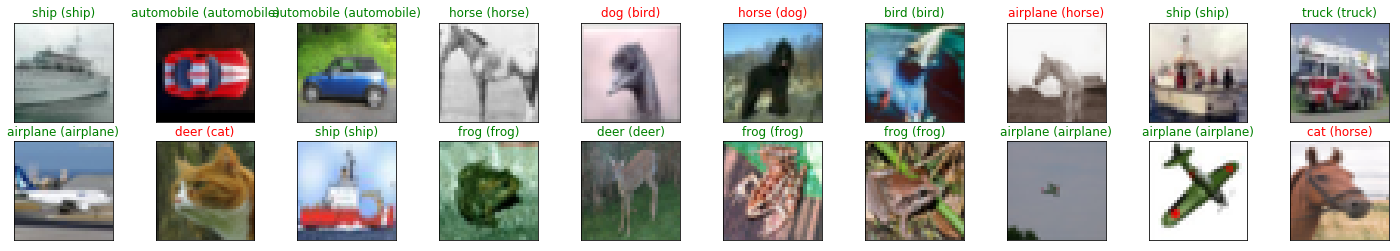

In [74]:
# obtain one batch of test images
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
